### Imports

In [3]:
import torch

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np


from torchvision import transforms, datasets
from tqdm import tqdm
from base import BaseVAE
from our_types import *

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else  'cpu'
device

'cuda'

In [5]:
def init_seeds(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

init_seeds()

### 1. Define Beta-VAE and train it

In [6]:
class BetaVAE(BaseVAE):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 Capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = Capacity_max_iter

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 7, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)

        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=7,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=7,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 15, padding= 1),
                            nn.Tanh())

    def encode(self, input: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: Tensor) -> Tensor:

        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough ti compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        self.num_iter += 1
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]
        kld_weight = kwargs['M_N']  # Account for the minibatch samples from the dataset

        recons_loss =F.mse_loss(recons, input[:,0:3,:,:])

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * kld_weight * kld_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight* (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [10]:
def train(autoencoder, dataloader, epochs=20):

    opt = torch.optim.Adam(autoencoder.parameters())

    best_loss = np.inf

    for epoch in range(epochs):
        
        print(f'Epoch {epoch+1}')

        running_loss = 0.0
        running_kld = 0.0
        running_recons = 0.0

        with tqdm(dataloader, unit='batch') as tepoch:

            for _, (images, labels) in enumerate(tepoch):
                
                images = images.to(device)

                # One hot encoding of the labels

                onehot_label = torch.zeros((labels.shape[0],5), dtype=int)
                onehot_label.scatter_(1, labels.unsqueeze(1), 1)
                repeated_encoding = onehot_label.view(len(labels), 5, 1, 1).repeat(1, 1, 176,176).to(device)

                # Stack encoding with image

                ext_img = torch.cat([images, repeated_encoding], dim=1)

                opt.zero_grad()
                x_hat = autoencoder(ext_img)
                all_losses = autoencoder.loss_function(*x_hat, M_N = 1/len(labels))
                all_losses['loss'].backward()
                opt.step()

                # Save model if loss is better than previous best

                if all_losses['loss'].item() < best_loss:
                    best_loss = all_losses['loss'].item()
                    torch.save({
                        'encoder': autoencoder.encoder.state_dict(),
                        'fc_mu': autoencoder.fc_mu.state_dict(),
                        'fc_var': autoencoder.fc_var.state_dict(),
                        'decoder_input': autoencoder.decoder_input.state_dict(),
                        'final_layer': autoencoder.final_layer.state_dict(),
                        'decoder': autoencoder.decoder.state_dict(),
                        'opt': opt.state_dict(),
                        'loss': all_losses['loss'].item(),
                    },f'beta_vae_{autoencoder.latent_dim}.pth')
                
                # Add to the running losses

                running_loss += all_losses['loss'].item()
                running_kld += all_losses['KLD'].item()
                running_recons += all_losses['Reconstruction_Loss'].item()

                # Print training process in the tepoch

                tepoch.set_postfix(loss=all_losses['loss'].item(), kld=all_losses['KLD'].item(), recons=all_losses['Reconstruction_Loss'].item())

        # Print training process in the epoch   

        print(f'Epoch {epoch+1} loss: {running_loss/len(dataloader)} kld: {running_kld/len(dataloader)} recons: {running_recons/len(dataloader)}')

    return autoencoder

In [8]:
# Define the path to your image folder
data_path = "res/datasets/PacMan_FearGhost_cropped_5actions_Unique/train"

# Define the transformations to be applied to the images
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # You can adjust the size as needed
    transforms.ToTensor(),
])

# Create the ImageFolder dataset
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Create the data loader
batch_size = 128  # You can adjust the batch size as needed
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
latent_dims = 12
nb_classes = 5

autoencoder = BetaVAE(in_channels=(3 + nb_classes), latent_dim=latent_dims).to(device) # GPU

data = data_loader

autoencoder = train(autoencoder, data)

0


100%|██████████| 285/285 [08:53<00:00,  1.87s/batch, kld=0.116, loss=0.248, recons=0.022]   


1


100%|██████████| 285/285 [08:57<00:00,  1.89s/batch, kld=0.116, loss=0.144, recons=0.012]   


2


100%|██████████| 285/285 [09:00<00:00,  1.90s/batch, kld=0.164, loss=0.256, recons=0.00497] 


3


100%|██████████| 285/285 [08:59<00:00,  1.89s/batch, kld=0.966, loss=3.41, recons=0.00637]   


4


100%|██████████| 285/285 [08:58<00:00,  1.89s/batch, kld=0.491, loss=0.678, recons=0.00423]  


5


100%|██████████| 285/285 [08:55<00:00,  1.88s/batch, kld=0.486, loss=0.298, recons=0.00469]  


6


100%|██████████| 285/285 [09:00<00:00,  1.90s/batch, kld=0.697, loss=0.996, recons=0.00438] 


7


100%|██████████| 285/285 [09:00<00:00,  1.90s/batch, kld=0.532, loss=0.193, recons=0.00382]  


8


100%|██████████| 285/285 [08:55<00:00,  1.88s/batch, kld=0.612, loss=0.15, recons=0.00353]   


9


100%|██████████| 285/285 [08:58<00:00,  1.89s/batch, kld=0.691, loss=0.112, recons=0.00358]  


10


100%|██████████| 285/285 [08:37<00:00,  1.82s/batch, kld=0.788, loss=0.0258, recons=0.00359] 


11


100%|██████████| 285/285 [09:01<00:00,  1.90s/batch, kld=0.863, loss=0.0417, recons=0.00347] 


12


100%|██████████| 285/285 [09:07<00:00,  1.92s/batch, kld=0.877, loss=0.249, recons=0.00349]  


13


100%|██████████| 285/285 [09:08<00:00,  1.93s/batch, kld=0.986, loss=0.0595, recons=0.00351] 


14


 92%|█████████▏| 262/285 [08:20<00:43,  1.90s/batch, kld=1.06, loss=0.0179, recons=0.0035]  

### Sample and check the reconstruction process

In [11]:
x, y = next(iter(data)) # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

In [12]:
# One hot encoding of the labels

onehot_label = torch.zeros((1,5), dtype=int)
onehot_label[0][1] = 1
repeated_encoding = onehot_label.view(1, 5, 1, 1).repeat(1, 1, 176,176).to(device)

# Stack encoding with image

ext_img = torch.cat([x_1.unsqueeze(0), repeated_encoding], dim=1)

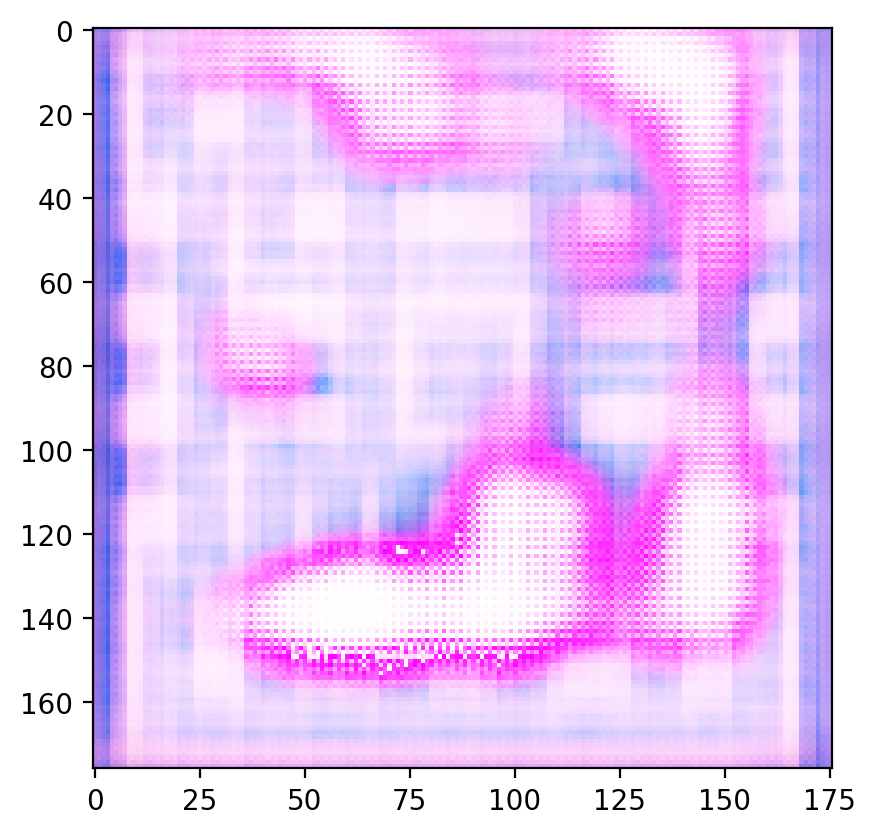

In [13]:
with torch.no_grad():

    # z = torch.Tensor([np.random.randn(latent_dims)]).to(device)

    mu, std = autoencoder.encode(ext_img)
    z = autoencoder.reparameterize(mu, std)
    x_hat = autoencoder.decode(z)

    img = (x_hat.cpu().detach().numpy().reshape(3, 176, 176).transpose(1, 2, 0) * 255).astype(np.uint8)

    plt.imshow(img)

In [10]:
x_hat.cpu().detach().numpy().reshape(3, 176, 176).shape

(3, 176, 176)

### 2. Latent space generator 

In [ ]:
# Create a neural network that generates a representation in the latent space from an image and a target action

class ActionEncoder(nn.Module):

    def __init__(self, latent_dim, nb_classes):
        super(ActionEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.nb_classes = nb_classes

        # Feature straction layers

        self.feature_extraction = nn.Sequential(
            nn.Conv2d(3, 32, 8, 4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1),
            nn.ReLU()
        )


        self.fc1 = nn.Linear(3 * 176 * 176, 512)
        self.fc_action = nn.Linear(nb_classes, 512)

        self.fc2 = nn.Linear(512 * 2, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, latent_dim)

    def forward(self, x, action):

        x = x.view(-1, 3 * 176 * 176)

        x = F.relu(self.fc1(x))
        action = F.relu(self.fc_action(action))

        # Stack image and action

        x = torch.cat([x, action], dim=1)

        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.fc4(x)

        return x

### Load policy for the ACER agent

In [ ]:
from src.util import load_baselines_model

# Load the model trained with the baselines library

agent_file = "../res/agents/ACER_PacMan_FearGhost2_cropped_5actions_40M_3"

agent = load_baselines_model(agent_file, num_actions=5, num_env=1)